## Baby Names Challenge (1910 - 2021)

#### Perguntas

1. Qual o nome masculino mais popular na Califórnia em todos os tempos?

2. Qual o nome mais popular e a quantidade de registros por estado?

3. Plotar um gráfico com a evolução de nascimento de meninos e meninas em todo os EUA.

#### Estrutura Arquivo

Campos separados por vírgula:
  - Estado (2 dígitos)
  - Sexo (M = Masculino / F = Feminino)
  - Ano de Nascimento (4 dígitos)
  - Nome (de 2 a 15 caracteres)
  - Número de ocorrências

In [31]:
import findspark
findspark.init()
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, avg, row_number, max
from pyspark.sql.types import StructType, StructField, IntegerType, StringType
from pyspark.sql.window import Window
from pathlib import Path

In [2]:
conf = SparkConf().setAppName("baby-names-challenge")
sc = SparkContext(conf=conf)
spark = SparkSession(sc)

In [3]:
def shape(df):
    return (df.count(), len(df.columns))

In [4]:
%%time
! hadoop fs -put ../datasets/baby-names

CPU times: user 594 ms, sys: 257 ms, total: 851 ms
Wall time: 22.4 s


In [5]:
! hadoop fs -ls hdfs://node-master:9000/user/root

Found 2 items
drwxr-xr-x   - root supergroup          0 2023-03-20 23:17 hdfs://node-master:9000/user/root/.sparkStaging
drwxr-xr-x   - root supergroup          0 2023-03-20 23:18 hdfs://node-master:9000/user/root/baby-names


In [6]:
! hadoop fs -ls hdfs://node-master:9000/user/root/baby-names

Found 52 items
-rw-r--r--   2 root supergroup     604325 2023-03-20 23:18 hdfs://node-master:9000/user/root/baby-names/AK.TXT
-rw-r--r--   2 root supergroup    2867454 2023-03-20 23:18 hdfs://node-master:9000/user/root/baby-names/AL.TXT
-rw-r--r--   2 root supergroup    2153187 2023-03-20 23:18 hdfs://node-master:9000/user/root/baby-names/AR.TXT
-rw-r--r--   2 root supergroup    2511859 2023-03-20 23:18 hdfs://node-master:9000/user/root/baby-names/AZ.TXT
-rw-r--r--   2 root supergroup    8299662 2023-03-20 23:18 hdfs://node-master:9000/user/root/baby-names/CA.TXT
-rw-r--r--   2 root supergroup    2314618 2023-03-20 23:18 hdfs://node-master:9000/user/root/baby-names/CO.TXT
-rw-r--r--   2 root supergroup    1753403 2023-03-20 23:18 hdfs://node-master:9000/user/root/baby-names/CT.TXT
-rw-r--r--   2 root supergroup    1175394 2023-03-20 23:18 hdfs://node-master:9000/user/root/baby-names/DC.TXT
-rw-r--r--   2 root supergroup     690194 2023-03-20 23:18 hdfs://node-master:9000/user/root/baby

## Q1

In [7]:
dataset_path = "hdfs://node-master:9000/user/root/baby-names"

In [8]:
# Estado (2 dígitos)
# Sexo (M = Masculino / F = Feminino)
# Ano de Nascimento (4 dígitos)
# Nome (de 2 a 15 caracteres)
# Número de ocorrências
schema = StructType([
    StructField("state", StringType(), True),
    StructField("gender", StringType(), True),
    StructField("yob", IntegerType(), True),
    StructField("name", StringType(), True),
    StructField("total", IntegerType(), True),
])

In [9]:
df_ca = spark.read.format(
    "csv"
).option(
    "header", "false"
).schema(
    schema
).load(
    f"{dataset_path}/CA.TXT"
)

In [10]:
shape(df_ca)

(400762, 5)

In [11]:
df_ca.show()

+-----+------+----+---------+-----+
|state|gender| yob|     name|total|
+-----+------+----+---------+-----+
|   CA|     F|1910|     Mary|  295|
|   CA|     F|1910|    Helen|  239|
|   CA|     F|1910|  Dorothy|  220|
|   CA|     F|1910| Margaret|  163|
|   CA|     F|1910|  Frances|  134|
|   CA|     F|1910|     Ruth|  128|
|   CA|     F|1910|   Evelyn|  126|
|   CA|     F|1910|    Alice|  118|
|   CA|     F|1910| Virginia|  101|
|   CA|     F|1910|Elizabeth|   93|
|   CA|     F|1910| Florence|   93|
|   CA|     F|1910|    Marie|   90|
|   CA|     F|1910|  Mildred|   90|
|   CA|     F|1910|     Rose|   74|
|   CA|     F|1910|    Hazel|   68|
|   CA|     F|1910|   Louise|   67|
|   CA|     F|1910|Josephine|   66|
|   CA|     F|1910|  Lucille|   66|
|   CA|     F|1910|    Grace|   65|
|   CA|     F|1910|   Gladys|   63|
+-----+------+----+---------+-----+
only showing top 20 rows



In [12]:
df_ca.filter(
    df_ca.gender == 'M'
).groupBy(
    df_ca.name
).agg(
    sum("total").alias("total")
).orderBy(
    col("total").desc()
).limit(10).show()

+-----------+------+
|       name| total|
+-----------+------+
|    Michael|432218|
|      David|375131|
|     Robert|351762|
|       John|314981|
|      James|284082|
|     Daniel|257911|
|    Richard|224869|
|Christopher|222791|
|    William|217961|
|    Anthony|183646|
+-----------+------+



## Q2

In [13]:
df_all = spark.read.format(
    "csv"
).option(
    "header", "false"
).schema(
    schema
).load(
    f"{dataset_path}/*.TXT"
)

In [14]:
shape(df_all)

(6311504, 5)

In [15]:
df_all.show()

+-----+------+----+---------+-----+
|state|gender| yob|     name|total|
+-----+------+----+---------+-----+
|   CA|     F|1910|     Mary|  295|
|   CA|     F|1910|    Helen|  239|
|   CA|     F|1910|  Dorothy|  220|
|   CA|     F|1910| Margaret|  163|
|   CA|     F|1910|  Frances|  134|
|   CA|     F|1910|     Ruth|  128|
|   CA|     F|1910|   Evelyn|  126|
|   CA|     F|1910|    Alice|  118|
|   CA|     F|1910| Virginia|  101|
|   CA|     F|1910|Elizabeth|   93|
|   CA|     F|1910| Florence|   93|
|   CA|     F|1910|    Marie|   90|
|   CA|     F|1910|  Mildred|   90|
|   CA|     F|1910|     Rose|   74|
|   CA|     F|1910|    Hazel|   68|
|   CA|     F|1910|   Louise|   67|
|   CA|     F|1910|Josephine|   66|
|   CA|     F|1910|  Lucille|   66|
|   CA|     F|1910|    Grace|   65|
|   CA|     F|1910|   Gladys|   63|
+-----+------+----+---------+-----+
only showing top 20 rows



In [16]:
df_state_name = df_all.groupBy(
    df_all.state, df_all.name
).agg(
    sum("total").alias("total")
).orderBy(
    col("total").desc()
)

In [27]:
df_state_name.printSchema()

root
 |-- state: string (nullable = true)
 |-- name: string (nullable = true)
 |-- total: long (nullable = true)



In [39]:
df_state_max_total = df_state_name.groupBy(
    df_all.state
).agg(
    max("total").alias("max_total")
).orderBy(
    col("state").desc()
)

In [40]:
shape(df_state_max_total)

(51, 2)

In [41]:
df_state_max_total.show()

+-----+---------+
|state|max_total|
+-----+---------+
|   WY|     9049|
|   WV|    76320|
|   WI|   105091|
|   WA|    70789|
|   VT|    11697|
|   VA|   150921|
|   UT|    29424|
|   TX|   282255|
|   TN|   174552|
|   SD|    18016|
|   SC|   129117|
|   RI|    29835|
|   PA|   421941|
|   OR|    40383|
|   OK|    75399|
|   OH|   279778|
|   NY|   499205|
|   NV|    14355|
|   NM|    23887|
|   NJ|   198284|
+-----+---------+
only showing top 20 rows



In [42]:
df_state_max_total.printSchema()

root
 |-- state: string (nullable = true)
 |-- max_total: long (nullable = true)



In [43]:
df_state_name_filtered_2 = df_state_name.join(
    df_state_max_total,
    ((df_state_name.state == df_state_max_total.state) &
     (df_state_name.total == df_state_max_total.max_total)),
    "inner"
).orderBy(
    col("total").desc()
)

In [44]:
shape(df_state_name_filtered_2)

(51, 5)

In [46]:
df_state_name_filtered_2.show()

+-----+-------+------+-----+---------+
|state|   name| total|state|max_total|
+-----+-------+------+-----+---------+
|   NY|   John|499205|   NY|   499205|
|   CA|Michael|434650|   CA|   434650|
|   PA|   John|421941|   PA|   421941|
|   TX|  James|282255|   TX|   282255|
|   OH| Robert|279778|   OH|   279778|
|   IL| Robert|278300|   IL|   278300|
|   MI| Robert|216465|   MI|   216465|
|   NC|  James|211587|   NC|   211587|
|   MA|   John|200674|   MA|   200674|
|   NJ|   John|198284|   NJ|   198284|
|   GA|  James|186446|   GA|   186446|
|   TN|  James|174552|   TN|   174552|
|   AL|  James|159682|   AL|   159682|
|   VA|  James|150921|   VA|   150921|
|   FL|Michael|146168|   FL|   146168|
|   KY|  James|145800|   KY|   145800|
|   IN| Robert|129140|   IN|   129140|
|   SC|  James|129117|   SC|   129117|
|   MO|  James|125717|   MO|   125717|
|   MS|  James|115889|   MS|   115889|
+-----+-------+------+-----+---------+
only showing top 20 rows



In [17]:
window_by_state = Window.partitionBy("state").orderBy(col("total").desc())

In [18]:
df_state_name_filtered = df_state_name.withColumn(
    "row_number", row_number().over(window_by_state)
).filter(
    col("row_number") == 1
).orderBy(
    col("total").desc()
)

In [26]:
shape(df_state_name_filtered)

(51, 4)

In [19]:
df_state_name_filtered.show()

+-----+-------+------+----------+
|state|   name| total|row_number|
+-----+-------+------+----------+
|   NY|   John|499205|         1|
|   CA|Michael|434650|         1|
|   PA|   John|421941|         1|
|   TX|  James|282255|         1|
|   OH| Robert|279778|         1|
|   IL| Robert|278300|         1|
|   MI| Robert|216465|         1|
|   NC|  James|211587|         1|
|   MA|   John|200674|         1|
|   NJ|   John|198284|         1|
|   GA|  James|186446|         1|
|   TN|  James|174552|         1|
|   AL|  James|159682|         1|
|   VA|  James|150921|         1|
|   FL|Michael|146168|         1|
|   KY|  James|145800|         1|
|   IN| Robert|129140|         1|
|   SC|  James|129117|         1|
|   MO|  James|125717|         1|
|   MS|  James|115889|         1|
+-----+-------+------+----------+
only showing top 20 rows



## Q3

In [20]:
df_total_by_yob = df_all.groupBy(
    col("yob"), col("gender")
).agg(
    sum(col("total")).alias("total")
).orderBy(
    col("yob").desc(), col("gender")
)

In [21]:
df_total_by_yob.show()

+----+------+-------+
| yob|gender|  total|
+----+------+-------+
|2021|     F|1320095|
|2021|     M|1492780|
|2020|     F|1303090|
|2020|     M|1478890|
|2019|     F|1360299|
|2019|     M|1545678|
|2018|     F|1382391|
|2018|     M|1570957|
|2017|     F|1405262|
|2017|     M|1606186|
|2016|     F|1446451|
|2016|     M|1654612|
|2015|     F|1458158|
|2015|     M|1677553|
|2014|     F|1459627|
|2014|     M|1683200|
|2013|     F|1425905|
|2013|     M|1654638|
|2012|     F|1426774|
|2012|     M|1657219|
+----+------+-------+
only showing top 20 rows



In [22]:
dfp = df_total_by_yob.toPandas()

In [23]:
foo = dfp.pivot(
    index="yob", columns="gender", values="total"
).reset_index(
    drop=False
)

In [24]:
foo

gender,yob,F,M
0,1910,352089,164223
1,1911,372382,193441
2,1912,504299,383704
3,1913,566973,461606
4,1914,696907,596441
...,...,...,...
107,2017,1405262,1606186
108,2018,1382391,1570957
109,2019,1360299,1545678
110,2020,1303090,1478890


<AxesSubplot:xlabel='yob'>

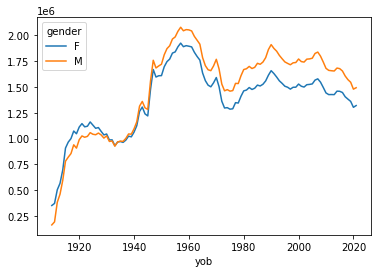

In [25]:
foo.plot.line(x="yob")